In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from geopy.distance import geodesic
import requests
from clingo import Control


In [2]:
# Load data from JSON
def read_json(file_path, encoding='utf-8'):
    with open(file_path, 'r', encoding=encoding) as file:
        data = json.load(file)
    return data

# Read data from JSON files
locations = read_json('../Data/locations.json')
location_types = read_json('../Data/LocationType.json')["RECORDS"]
routes = read_json('../Data/distances.json')
trucks = read_json('../Data/trucks.json')
containers = read_json('../Data/containers.json')
orders = read_json('../Data/orders.json')


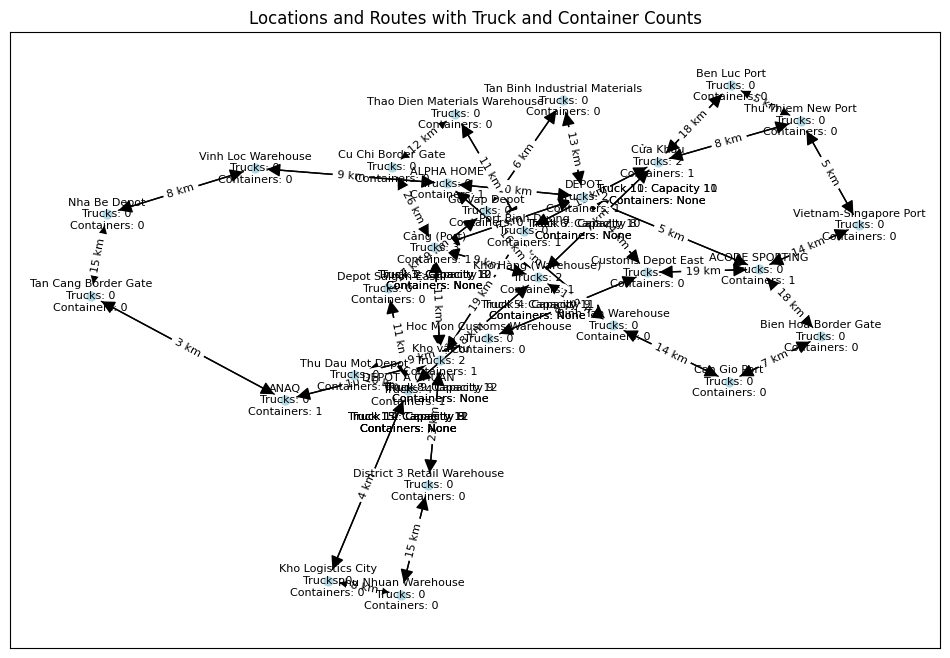

In [3]:
# Initialize a directed graph
G = nx.DiGraph()

# Add nodes with location type as a label
for loc in locations:
    loc_type = loc["Type"] if loc["Type"] else "Unknown"
    G.add_node(loc["LocationID"], label=f'{loc["Name"]} ({loc_type})')

# Add edges with distances as weights
for route in routes:
    G.add_edge(route["From"], route["To"], weight=route["DistanceKm"])

# Count trucks and containers at each location
location_trucks = defaultdict(int)
location_containers = defaultdict(int)
truck_conts = defaultdict(list)

for truck in trucks:
    location_trucks[truck["current_location"]] += 1
    if truck["conts"] is not None:
        for cont in truck["conts"]:
            truck_conts[truck["CarID"]].append(f'{cont["ContNumber"]} ({cont["Status"]})')

for container in containers:
    location_containers[container["ArrLocationDepotCode"][0]] += 1  # Assuming the first location in ArrLocationDepotCode is the current location

# Set up node labels to include truck and container counts
node_labels = {loc["LocationID"]: f'{loc["Name"]}\nTrucks: {location_trucks[loc["LocationID"]]}\nContainers: {location_containers[loc["LocationID"]]}' for loc in locations}

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
plt.figure(figsize=(12, 8))

# Draw nodes with labels
nx.draw_networkx_nodes(G, pos, node_size=40, node_color='lightblue')
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

# Draw edges with weights
edge_labels = {(u, v): f'{d["weight"]} km' for u, v, d in G.edges(data=True)}
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Add truck information to the plot
for truck in trucks:
    if truck["conts"] is not None:
        truck_info = f'Truck {truck["CarID"]}: Capacity {truck["capacity"]}\nContainers: {"; ".join(truck_conts[truck["CarID"]])}'
    else:
        truck_info = f'Truck {truck["CarID"]}: Capacity {truck["capacity"]}\nContainers: None'
    plt.text(pos[truck["current_location"]][0], pos[truck["current_location"]][1] - 0.1, truck_info, fontsize=8, ha='center')

plt.title("Locations and Routes with Truck and Container Counts")
plt.show()

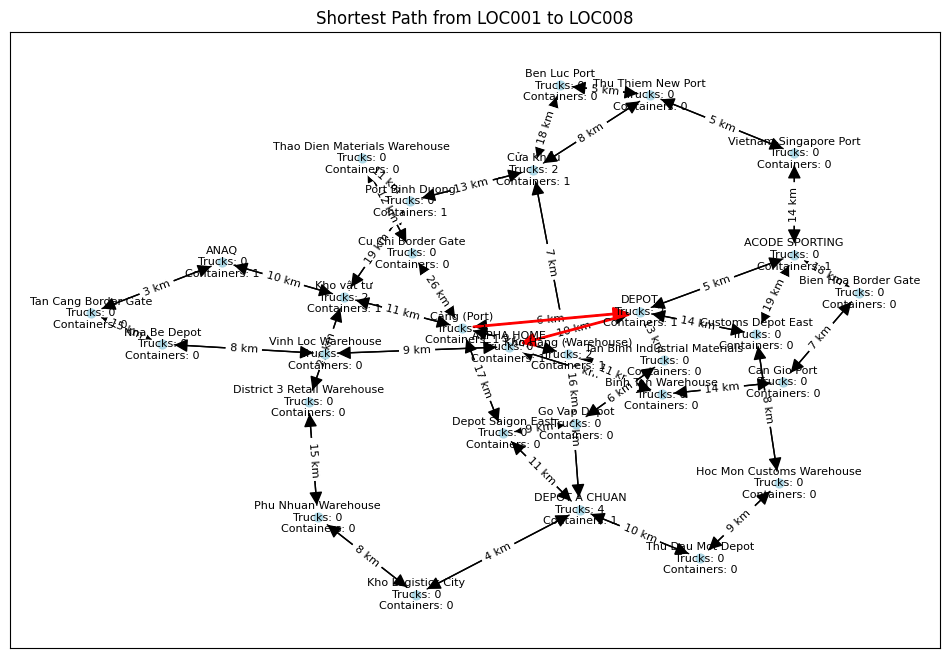

Shortest path from LOC001 to LOC008 is ['LOC001', 'LOC003', 'LOC008'] with a distance of 16 km
Added new location: {'LocationID': 'LOC_NEW', 'Name': 'New Location', 'Address': '123 New St', 'Coordinates': [10.9877, 104.749], 'Type': 'New'}
Nearest locations: [('LOC024', 190.6167807677952), ('LOC027', 193.16151496578837), ('LOC021', 201.24734988664449), ('LOC013', 203.9818670406868), ('LOC015', 204.19398956193044)]


In [4]:


# Function to find the shortest path using Dijkstra's algorithm and visualize it
def find_shortest_path_and_visualize(G, source, target):
    try:
        length, path = nx.single_source_dijkstra(G, source=source, target=target)
        
        # Visualize the graph with the shortest path highlighted
        pos = nx.spring_layout(G)  # positions for all nodes
        plt.figure(figsize=(12, 8))

        # Draw nodes with labels
        nx.draw_networkx_nodes(G, pos, node_size=40, node_color='lightblue')
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

        # Draw edges with weights
        edge_labels = {(u, v): f'{d["weight"]} km' for u, v, d in G.edges(data=True)}
        nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

        # Highlight the shortest path
        path_edges = list(zip(path, path[1:]))
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2, arrowstyle='-|>', arrowsize=20)

        plt.title(f"Shortest Path from {source} to {target}")
        plt.show()
        
        return length, path
    except nx.NetworkXNoPath:
        return float('inf'), []

# Function to add a new location and update the graph
def add_new_location(locations, routes, G, LocationID, Name, Address, Coordinates):
    new_location = {
        "LocationID": LocationID,
        "Name": Name,
        "Address": Address,
        "Coordinates": Coordinates,
        "Type": "New"
    }
    locations.append(new_location)
    
    G.add_node(LocationID, label=f'{Name} (New)')
    
    print(f'Added new location: {new_location}')

    # Find 5 nearest existing locations
    nearest_locations = []
    for loc in locations:
        if loc["LocationID"] != LocationID:
            loc_coords = loc.get("Coordinates")
            if loc_coords:
                if isinstance(loc_coords, dict):  # Handle dictionary coordinates
                    loc_coords = [loc_coords["x"], loc_coords["y"]]
                if len(loc_coords) == 2:
                    try:
                        distance = geodesic((Coordinates[0], Coordinates[1]), (loc_coords[0], loc_coords[1])).km
                        nearest_locations.append((loc["LocationID"], distance))
                    except Exception as e:
                        print(f'Error calculating distance between {Coordinates} and {loc_coords}: {e}')
                else:
                    print(f'Skipping location {loc["LocationID"]} due to invalid coordinates length: {loc_coords}')
            else:
                print(f'Skipping location {loc["LocationID"]} due to missing coordinates')

    nearest_locations = sorted(nearest_locations, key=lambda x: x[1])[:5]

    print(f'Nearest locations: {nearest_locations}')
    
    # Add new edges
    for loc_id, distance in nearest_locations:
        routes.append({
            "From": LocationID,
            "To": loc_id,
            "DistanceKm": distance
        })
        routes.append({
            "From": loc_id,
            "To": LocationID,
            "DistanceKm": distance
        })
        G.add_edge(LocationID, loc_id, weight=distance)
        G.add_edge(loc_id, LocationID, weight=distance)


    with open('../Data/locations.json', 'w', encoding='utf-8') as file:
        json.dump(locations, file, ensure_ascii=False, indent=4)
    
    with open('../Data/distances.json', 'w', encoding='utf-8') as file:
        json.dump(routes, file, ensure_ascii=False, indent=4)

length, path = find_shortest_path_and_visualize(G, "LOC001", "LOC008")
print(f'Shortest path from LOC001 to LOC008 is {path} with a distance of {length} km')

add_new_location(locations, routes, G, "LOC_NEW", "New Location", "123 New St", [10.9877, 104.749])


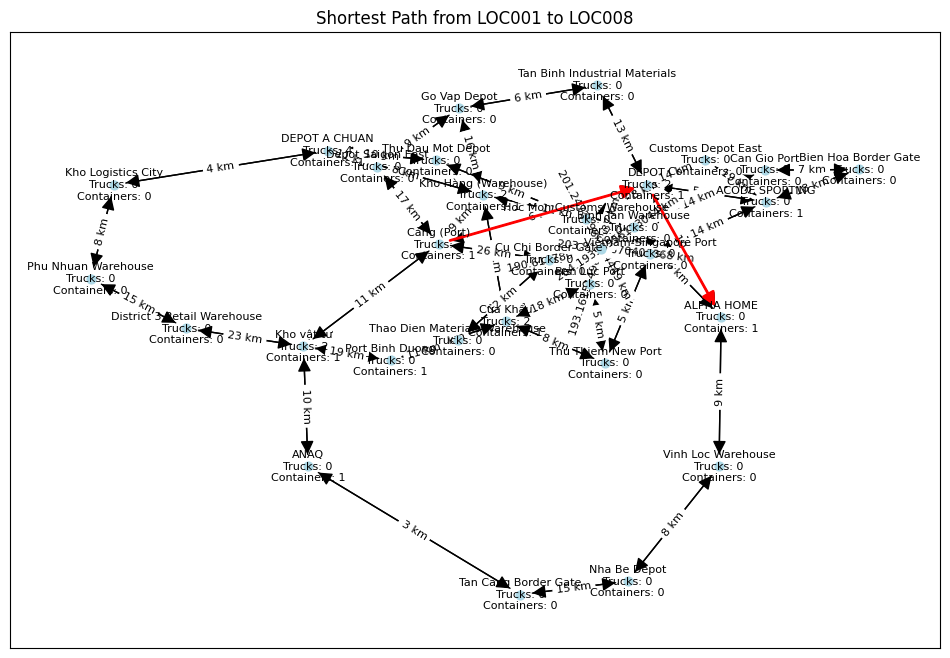

Shortest path from LOC001 to LOC008 is ['LOC001', 'LOC003', 'LOC008'] with a distance of 16 km


C:\Users\Minh\AppData\Local\Temp\ipykernel_14088\2212525440.py:21: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2, arrowstyle='-|>', arrowsize=20)


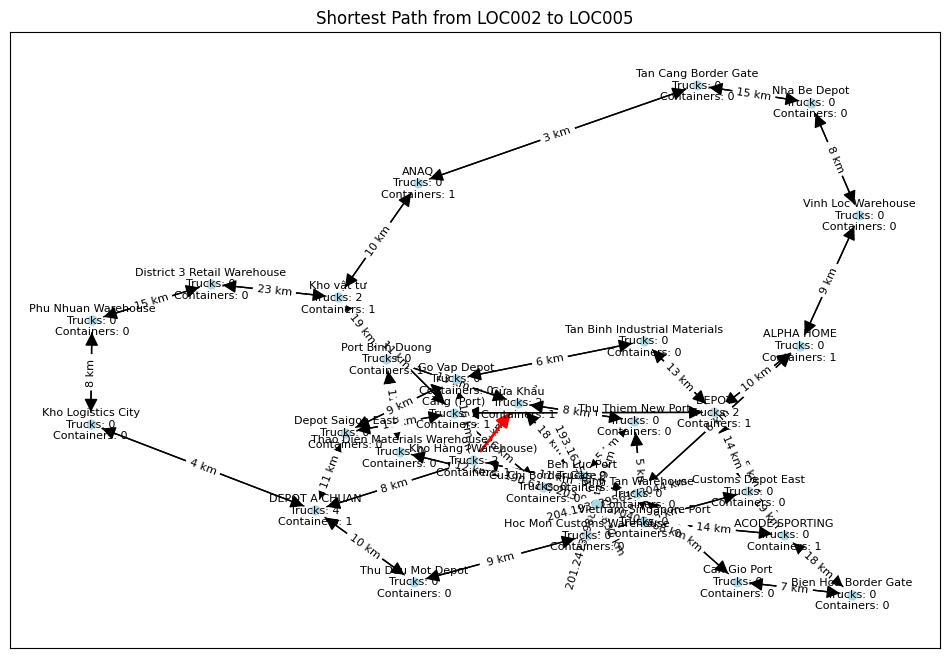

Shortest path from LOC002 to LOC005 is ['LOC002', 'LOC005'] with a distance of 8 km


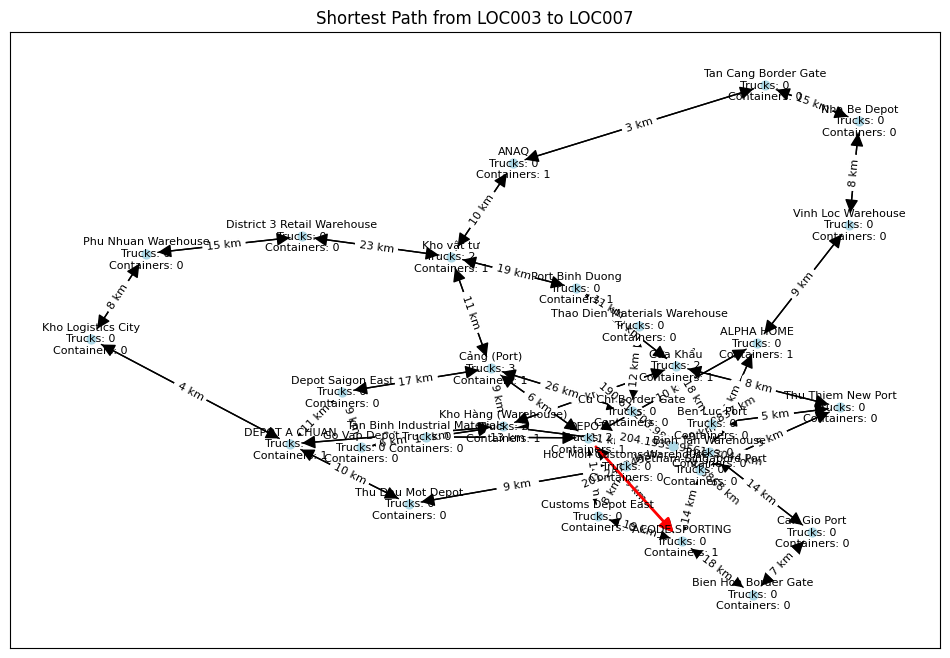

Shortest path from LOC003 to LOC007 is ['LOC003', 'LOC007'] with a distance of 6 km
Route for LOC001 -> LOC008: Path = ['LOC001', 'LOC003', 'LOC008'], Distance = 16 km
Route for LOC002 -> LOC005: Path = ['LOC002', 'LOC005'], Distance = 8 km
Route for LOC003 -> LOC007: Path = ['LOC003', 'LOC007'], Distance = 6 km


In [6]:
# Function to find the most optimized route for an array of tasks
def find_optimized_routes_for_tasks(G, tasks):
    optimized_routes = {}
    
    for task in tasks:
        source, target = task
        length, path = find_shortest_path_and_visualize(G, source, target)
        optimized_routes[f'{source} -> {target}'] = {
            'path': path,
            'length': length
        }
        
        print(f'Shortest path from {source} to {target} is {path} with a distance of {length} km')
    
    return optimized_routes

tasks = [
    ("LOC001", "LOC008"),
    ("LOC002", "LOC005"),
    ("LOC003", "LOC007")
]

optimized_routes = find_optimized_routes_for_tasks(G, tasks)

# Print the optimized routes
for task, route_info in optimized_routes.items():
    print(f'Route for {task}: Path = {route_info["path"]}, Distance = {route_info["length"]} km')

In [9]:
# New function to find the shortest path from a start location to an array of locations, and sort them by distance
def find_and_sort_nearest_locations(G, start_location, locations_array):
    distances = []
    
    for location in locations_array:
        length, _ = nx.single_source_dijkstra(G, source=start_location, target=location)
        distances.append((location, length))
    
    # Sort locations by distance
    sorted_locations = sorted(distances, key=lambda x: x[1])
    
    # Print out the nearest location
    nearest_location = sorted_locations[0]
    print(f'Nearest location to {start_location} is {nearest_location[0]} with a distance of {nearest_location[1]} km')
    
    return sorted_locations

start_location = "LOC001"
locations_array = ["LOC005", "LOC007", "LOC008", "LOC003"]

sorted_nearest_locations = find_and_sort_nearest_locations(G, start_location, locations_array)

# Print sorted locations
print("Sorted locations by distance:")
for loc, dist in sorted_nearest_locations:
    print(f'{start_location} -> {loc}: {dist} km')

Nearest location to LOC001 is LOC003 with a distance of 5 km
Sorted locations by distance:
LOC001 -> LOC003: 5 km
LOC001 -> LOC007: 11 km
LOC001 -> LOC008: 16 km
LOC001 -> LOC005: 18 km


# RULEBOOK

In [ ]:
# Print the read data for verification
print("Locations:", locations)
print("Location Types:", location_types)
print("Routes:", routes)
print("Trucks:", trucks)
print("Orders:", orders)
print("Containers:", containers)

In [32]:
def generate_asp_code(locations, routes, trucks, orders, containers):
    asp_code = ""

    # Define locations and types
    for loc in locations:
        asp_code += f'location({loc["LocationID"]}).\n'
        asp_code += f'location_type({loc["LocationID"]}, "{loc["Type"]}").\n'

    # Define routes and distances between locations
    for route in routes:
        asp_code += f'route({route["From"]}, {route["To"]}, {route["DistanceKm"]}).\n'

    # Define trucks
    for truck in trucks:
        asp_code += f'truck({truck["CarID"]}).\n'
        asp_code += f'capacity({truck["CarID"]}, {truck["capacity"]}).\n'
        asp_code += f'current_location({truck["CarID"]}, {truck["current_location"]}).\n'

    # Define containers
    for container in containers:
        asp_code += f'container({container["ContNumber"]}).\n'
        order_id = container["OrderId"] if container["OrderId"] else "null"
        asp_code += f'current_truck({container["ContNumber"]}, {order_id}).\n'
        asp_code += f'is_cargo({container["ContNumber"]}, {str(container["IsCargo"]).lower()}).\n'

    # Define tasks from orders
    for order in orders:
        if order["OrderType"] == "Booking":
            asp_code += f'order({order["Code"]}, booking, {order["ArrLocationReciptCode"][0]}, {order["ArrLocationReciptCode"][1]}, {order["Book_ETA"]}, {order["Book_ATA"]}).\n'
        elif order["OrderType"] == "Bill":
            asp_code += f'order({order["Code"]}, bill, {order["ArrLocationReciptCode"][0]}, {order["ArrLocationReciptCode"][1]}, {order["Bill_ETD"]}, {order["Bill_LastFreeDayDET"]}).\n'

    # Assign tasks to trucks
    asp_code += "{ assigned(T, K) : truck(K) } = 1 :- order(T, _, _, _, _, _).\n"

    # Define the route taken by each truck
    asp_code += "{ travel(K, L1, L2) : route(L1, L2, _) } :- truck(K).\n"

    # Ensure routes are valid
    asp_code += ":- travel(K, L1, L2), not location(L1), not location(L2).\n"

    # Constraints to prioritize tasks with tighter deadlines and minimize travel distances
    asp_code += ":- assigned(T1, K), assigned(T2, K), order(T1, booking, _, _, _, _), order(T2, bill, _, _, _, _), T1 < T2.\n"
    asp_code += ":- travel(K, L1, L2), travel(K, L2, L3), route(L1, L2, D1), route(L2, L3, D2), D1 > D2.\n"
    asp_code += ":- assigned(T, K), capacity(K, C), container(T), is_cargo(T, L), L > C.\n"

    # Show assigned tasks and routes
    asp_code += "#show assigned/2.\n"
    asp_code += "#show travel/3.\n"

    return asp_code

# Generate ASP code
asp_code = generate_asp_code(locations, routes, trucks, orders, containers)
print(asp_code)

# Solve the VRP using Clingo
ctl = Control()
try:
    ctl.add("base", [], asp_code)
    ctl.ground([("base", [])])
except RuntimeError as e:
    print("Error adding or grounding ASP code:", e)
    print("ASP Code:", asp_code)
    raise

def on_model(m):
    print("Model found:")
    for atom in m.symbols(shown=True):
        print(atom)

result = ctl.solve(on_model=on_model)

if result.satisfiable:
    print("Solution found!")
else:
    print("No solution found.")


location(LOC001).
location_type(LOC001, "Port").
location(LOC002).
location_type(LOC002, "Warehouse").
location(LOC003).
location_type(LOC003, "Depot").
location(LOC004).
location_type(LOC004, "Kho_vat_tu").
location(LOC005).
location_type(LOC005, "Cua_khau").
location(LOC006).
location_type(LOC006, "Depot").
location(LOC007).
location_type(LOC007, "None").
location(LOC008).
location_type(LOC008, "None").
location(LOC009).
location_type(LOC009, "None").
location(LOC010).
location_type(LOC010, "Port").
location(LOC011).
location_type(LOC011, "Depot").
location(LOC012).
location_type(LOC012, "Warehouse").
location(LOC013).
location_type(LOC013, "Port").
location(LOC014).
location_type(LOC014, "Depot").
location(LOC015).
location_type(LOC015, "Warehouse").
location(LOC016).
location_type(LOC016, "Cua_khau").
location(LOC017).
location_type(LOC017, "Kho_vat_tu").
location(LOC018).
location_type(LOC018, "Depot").
location(LOC019).
location_type(LOC019, "Warehouse").
location(LOC020).
locati

RuntimeError: too many messages.